# Assignment

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np

In [2]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife\bald_eagle
oregon_wildlife\black_bear
oregon_wildlife\cougar
oregon_wildlife\deer
oregon_wildlife\nutria
oregon_wildlife\raccoon
oregon_wildlife\raven
oregon_wildlife\red_fox
oregon_wildlife\sea_lions
oregon_wildlife\virginia_opossum

total img num: 7168


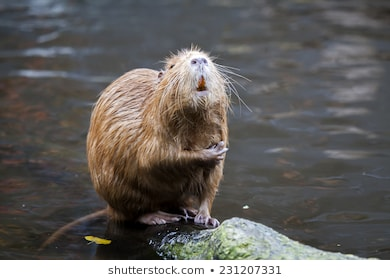

nutria


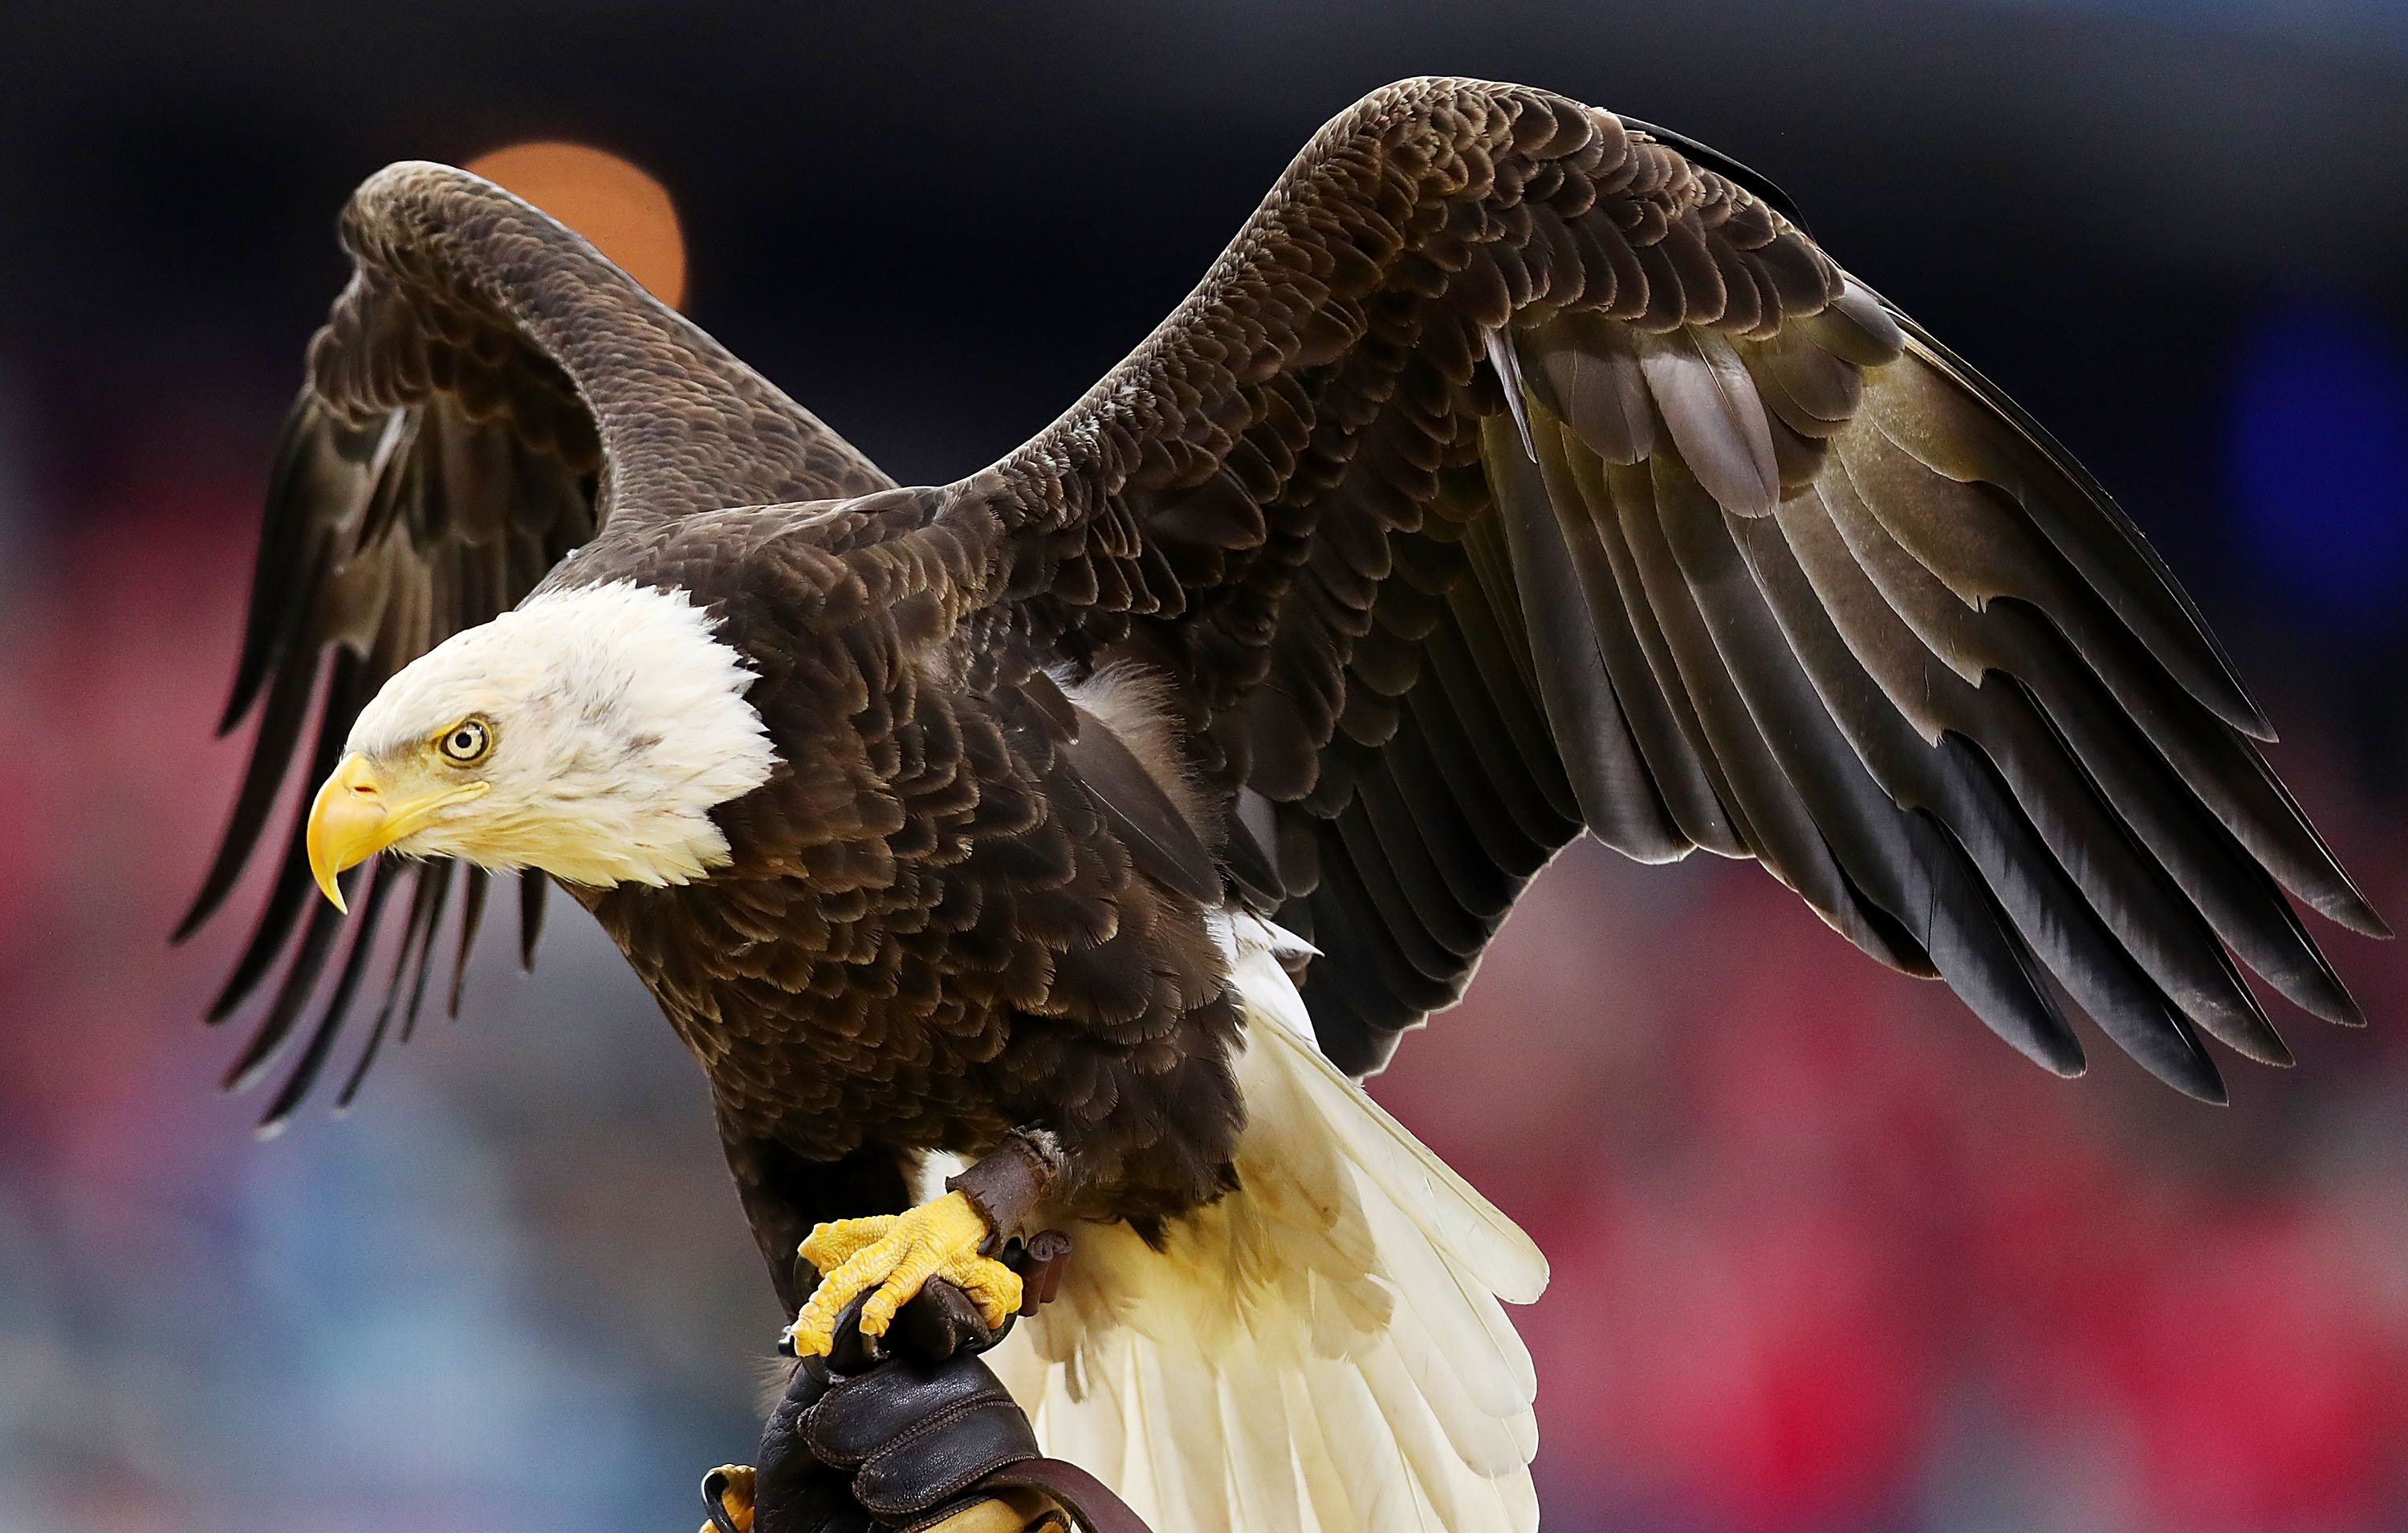

bald_eagle


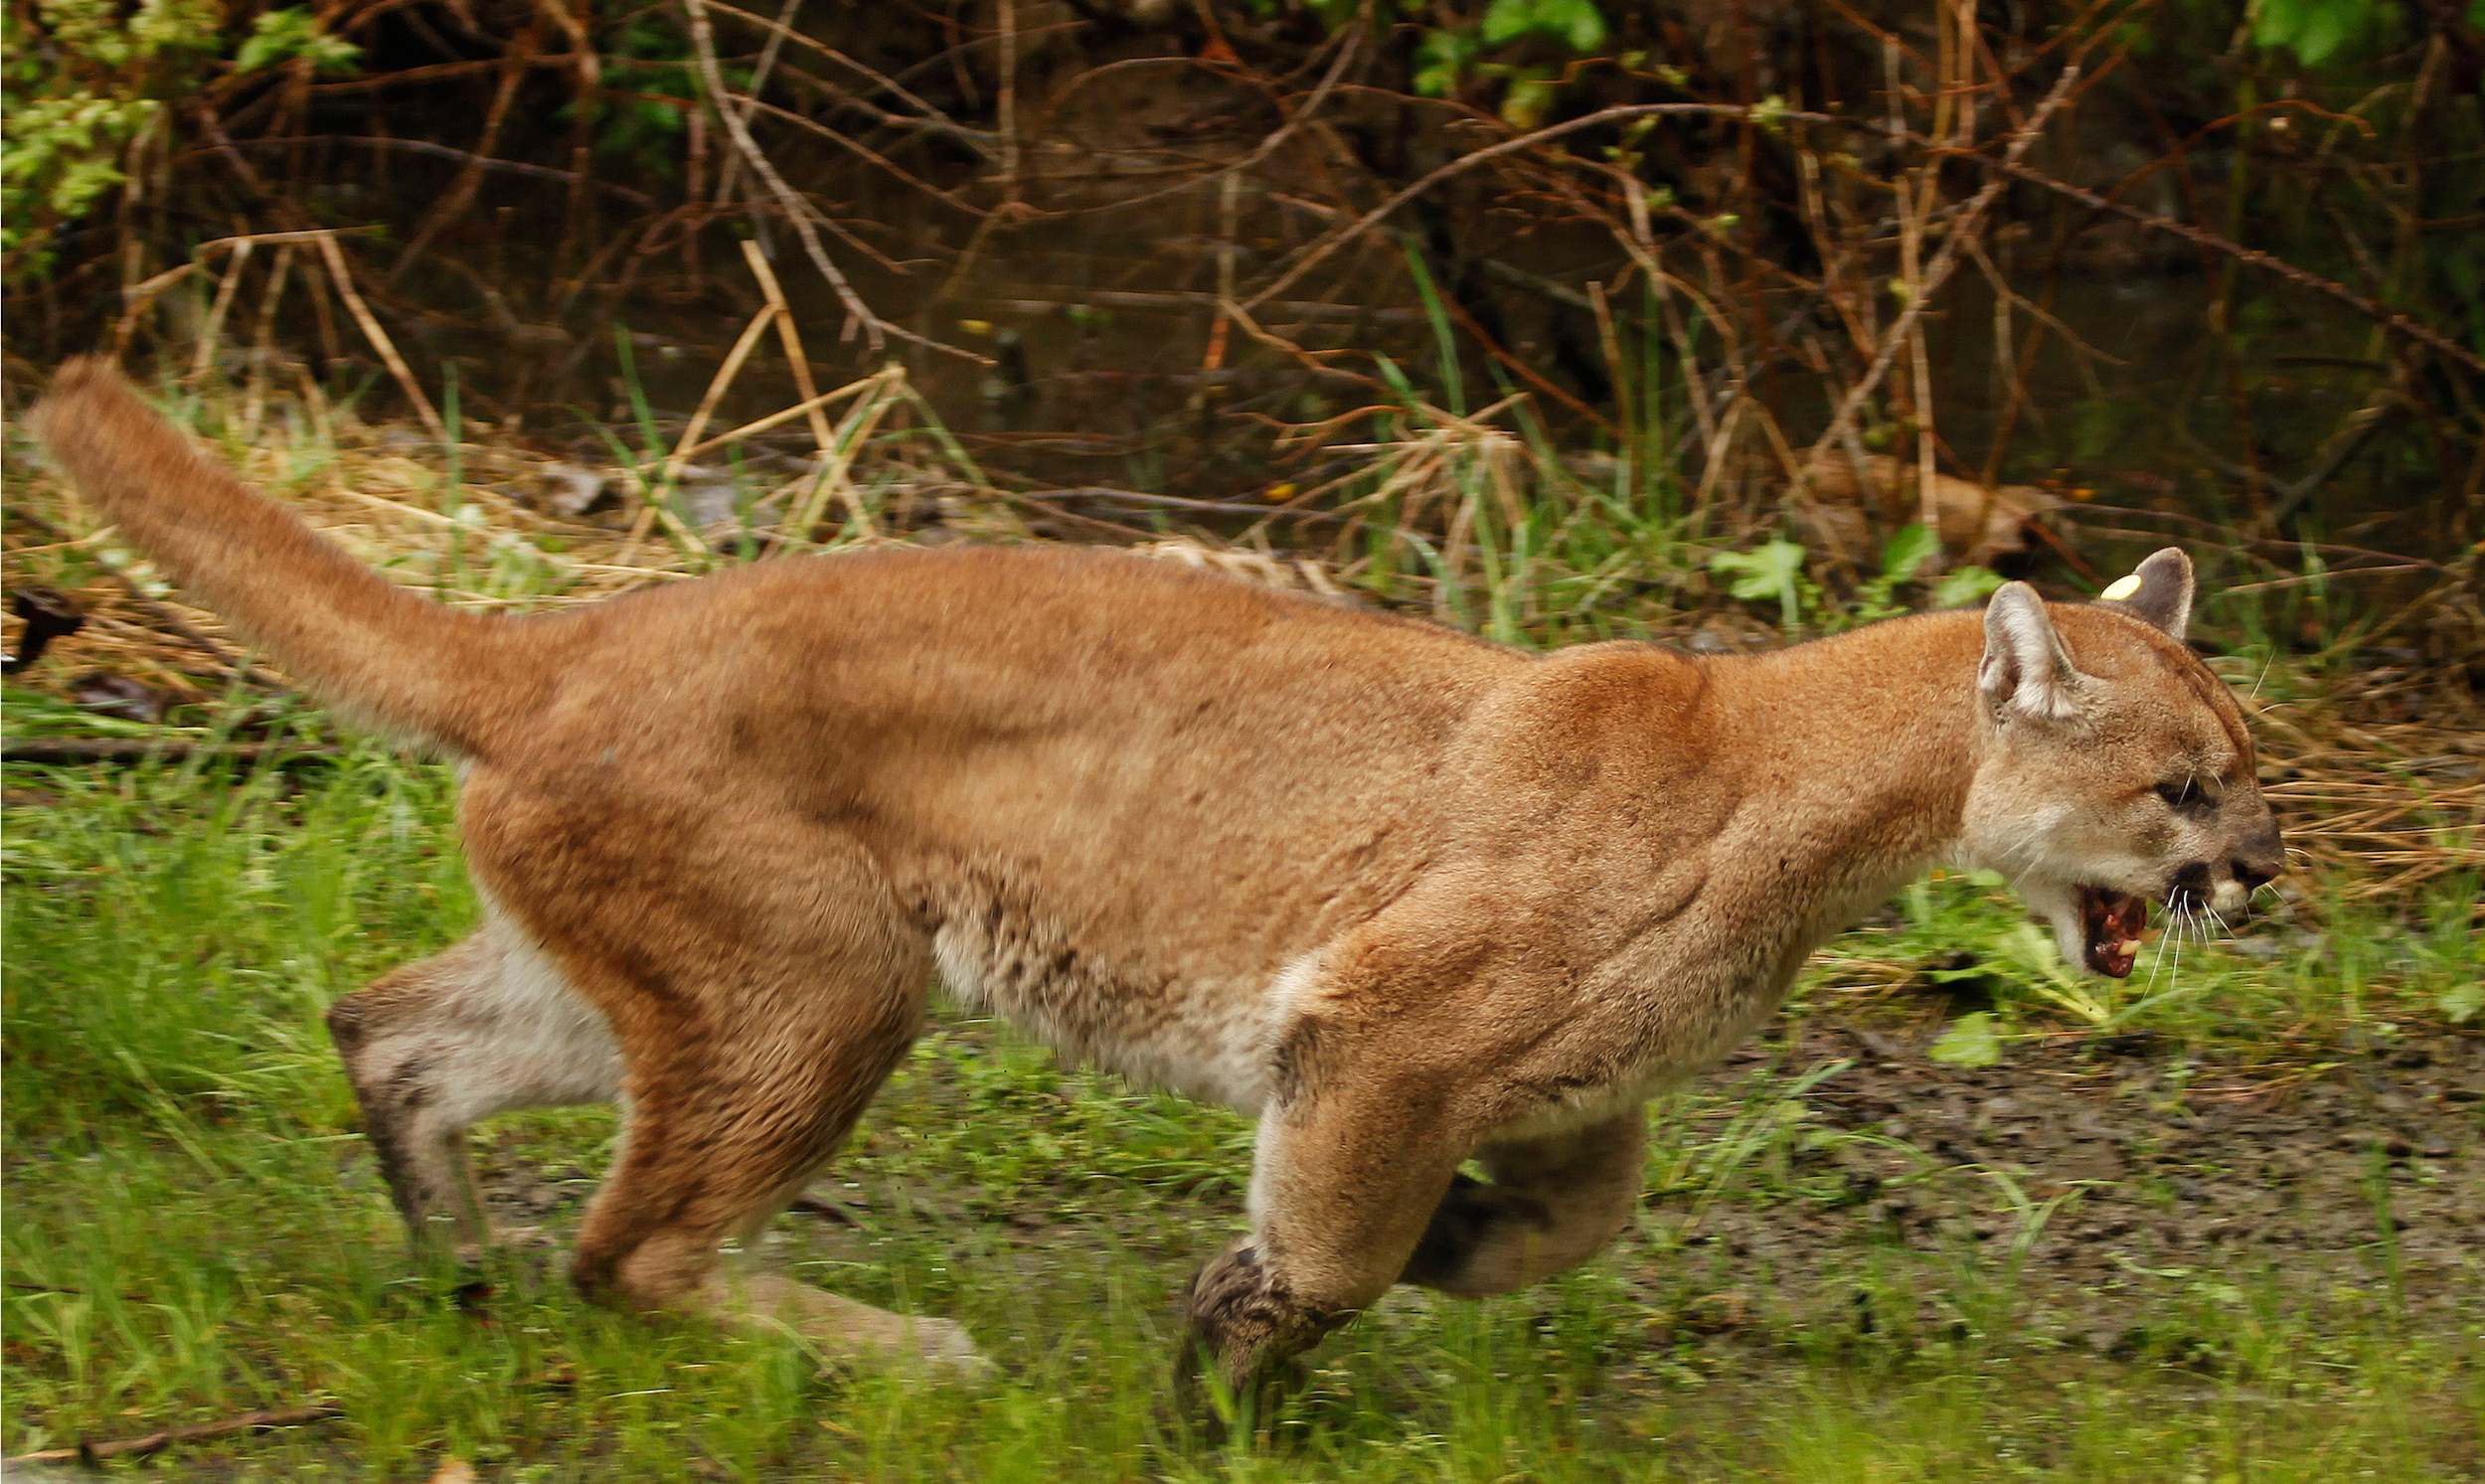

cougar


In [3]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('\\')[-2])

In [4]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [5]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [6]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [7]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [8]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 2000
BATCH_SIZE = 32

In [9]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)
    return img, label

In [10]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
# dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
# dataset_val = dataset_val.map(load_image)

print(dataset_train)
print(dataset_val)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>
<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>


In [11]:
# Use tf.data API to:
    # todo1:
        # write the dataset above to tfrecord
    # todo2:
        # read the data from tfrecord you get in Todo1
    # todo3:
        # remember to preprocess the data. You can refer to the code in the Cifar10 section.

## Write the Dataset to TFRecord

In [12]:
# The following functions can be used to convert a value to a type compatible with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [13]:
def serialized_example(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.cast(img, tf.string)

    feature = {
        'image': _bytes_feature(img),
        'label': _int64_feature(label)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [14]:
def tf_serialize_example(img_path, label):
    tf_string = tf.py_function(
        serialized_example,
        (img_path, label),  # pass these args to the above function.
        tf.string)     # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [15]:
def write_TFRecord(dataset, file):
    serialized_dataset = dataset.map(tf_serialize_example)
    print(serialized_dataset)
    filename = file
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_dataset)
    print(f'File write: {file}')

In [16]:
write_TFRecord(dataset_train, 'train.tfrecord')
write_TFRecord(dataset_val, 'validation.tfrecord')

<MapDataset shapes: (), types: tf.string>
Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`
File write: train.tfrecord
<MapDataset shapes: (), types: tf.string>
File write: validation.tfrecord


## Read the Data from TFRecord

In [17]:
feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=0)
    }

def map_train(example_proto):
    features = tf.io.parse_single_example(example_proto, feature_description)

    img = tf.image.decode_jpeg(features['image'], channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.divide(tf.cast(img, tf.float32), 255.0)
    distorted_image = tf.image.random_crop(img, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    label = tf.cast(features['label'], tf.int64)
    # label = tf.one_hot(label, n_classes)

    return distorted_image, label

def map_test(example_proto):
    features = tf.io.parse_single_example(example_proto, feature_description)

    img = tf.image.decode_jpeg(features['image'], channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.divide(tf.cast(img, tf.float32), 255.0)
    distorted_image = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    label = tf.cast(features['label'], tf.int64)
    # label = tf.one_hot(label, n_classes)

    return distorted_image, label

In [18]:
def read_TFRecord(filename):
    filenames = [filename]
    raw_dataset = tf.data.TFRecordDataset(filenames)
    return raw_dataset

dataset_train = read_TFRecord('train.tfrecord')
dataset_train = dataset_train.map(map_train)
dataset_val = read_TFRecord('validation.tfrecord')
dataset_val = dataset_val.map(map_test)
print(dataset_train)
print(dataset_val)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [19]:
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


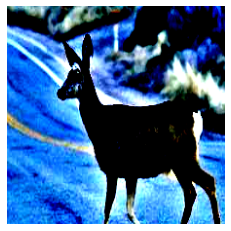

deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


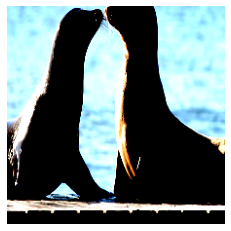

sea_lions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


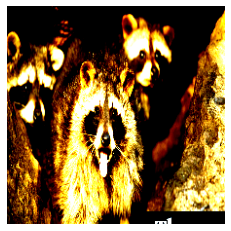

raccoon


In [20]:
# show one image here.
for img, label in dataset_train.take(3):
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print(index_to_label[label[0].numpy()])

In [21]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [23]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train, validation_data=dataset_val, epochs=5)

Epoch 1/5
180/180 [==============================] - 104s 407ms/step - loss: 2.4651 - accuracy: 0.5633 - val_loss: 0.4682 - val_accuracy: 0.8494
Epoch 2/5
180/180 [==============================] - 88s 364ms/step - loss: 0.7319 - accuracy: 0.7654 - val_loss: 0.3190 - val_accuracy: 0.9010
Epoch 3/5
180/180 [==============================] - 91s 365ms/step - loss: 0.5677 - accuracy: 0.8214 - val_loss: 0.2616 - val_accuracy: 0.9107
Epoch 4/5
180/180 [==============================] - 91s 371ms/step - loss: 0.5400 - accuracy: 0.8312 - val_loss: 0.2294 - val_accuracy: 0.9310
Epoch 5/5
180/180 [==============================] - 91s 371ms/step - loss: 0.4873 - accuracy: 0.8509 - val_loss: 0.2373 - val_accuracy: 0.9226


## Reference
<code>TFRecords file I/O: https://blog.gtwang.org/programming/tensorflow-read-write-tfrecords-data-format-tutorial/</code>